In [13]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import pickle

from scipy import stats

sns.set_style("ticks")

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor

%matplotlib inline

from os import walk

import copy

In [14]:
nCMs = 9

from functools import lru_cache

def grab_traces(name="baseline", verbose=False):
    files_found = 0
    all_traces = []
    for i, (dirpath, dirnames, filenames) in enumerate(walk(f"cm_traces/{name}")):
        for f in filenames:
            if "_combined" in f and ".txt" in f and "rhat" not in f and "ess" not in f:
                
                if name == "additive" and "_base.txt" in f:
                    continue
                    
                if "default" in f:
                    default_res = np.loadtxt(dirpath+"/"+f)
                    print("Found default results.")
        
        
        for f in filenames:
            if "_combined" in f and ".txt" in f and "rhat" not in f and "ess" not in f and "default" not in f:
                
                if name == "additive" and "_base.txt" in f:
                    continue
                    
                trace = 100*(1-np.loadtxt(dirpath+"/"+f))

                files_found += 1
                trace_med = np.median(trace, axis=0)
                trace_std = np.std(trace, axis=0)
                f_nCMs = trace_med.shape[0]
                if f_nCMs > nCMs:
                    trace_med = trace_med[:nCMs]
                    trace_std = trace_med[:nCMs]
                elif f_nCMs < nCMs:
#                     print(trace_med)
                    leaveout_num = int(f[-5])
#                     print(f"leavout_num is {leaveout_num}")
                    trace_med = np.insert(trace_med, leaveout_num, np.median(default_res, axis=0)[leaveout_num])
                    trace_std = np.insert(trace_std, leaveout_num, 0)
#                     print(trace_med)

                trace_obj = copy.deepcopy((trace, trace_med, trace_std))
                all_traces.append(trace_obj)

                if verbose:
                    print(f"Importing {f}")
                    
    print(f"Found {files_found} tests")
    return default_res, all_traces

def summarise_traces(trace_info):
    num_tests = len(trace_info)
    all_medians = np.zeros((num_tests, nCMs))
    all_stds = np.zeros((num_tests, nCMs))
    
    for t in range(num_tests):
        all_medians[t, :] = trace_info[t][1]
        all_stds[t, :] = trace_info[t][2]
    
    std_medians =  np.std(all_medians, axis=0)
    std_stds =  np.std(all_stds, axis=0) 
    return std_medians, std_stds

In [15]:
derived_features = [
 ("Mask Wearing", [1-1]),
 ("Symptomatic Testing", [2-1]),
 ("Gatherings <1000", [3-1]),
 ("Gatherings <100", [3-1, 4-1]),
 ("Gatherings <10", [3-1, 4-1, 5-1]),
 ("Some Businesses Suspended", [6-1]),
 ("Most Businesses Suspended", [6-1, 7-1]),
 ("School Closure", [8-1]),
 ("Stay Home Order", [9-1]),  
 ]

def produce_ranges(trace):
    means = np.mean(trace, axis=0)
    med = np.median(trace, axis=0)
    li = np.percentile(trace, 2.5, axis=0)
    ui = np.percentile(trace, 97.5, axis=0)
    lq = np.percentile(trace, 25, axis=0)
    uq = np.percentile(trace, 75, axis=0)
    return means, med, li, ui, lq, uq

def add_trace_to_plot(res, y_off, col, label, alpha, additive=False):
    nS, _ = res.shape
    nF = len(derived_features)
    derived_samples = np.zeros((nS, nF))

    if not additive:
        for f_i, (f, prodrows) in enumerate(derived_features):
            samples = np.ones(nS)
            for r in prodrows:
                samples = samples * res[:, r] 
            derived_samples[:, f_i] = samples

        res = derived_samples
        res = 100*(1-res)
    else:
        for f_i, (f, prodrows) in enumerate(derived_features):
            samples = np.zeros(nS)
            for r in prodrows:
                samples += res[:, r] 
            derived_samples[:, f_i] = samples

        res = derived_samples
        res = 100*res
    
    y_vals = -1 * np.arange(nF)
    
    plt.plot(-10, -10, color=col, linewidth=1, alpha=alpha, label=label)
    mn, med, li, ui, lq, uq = produce_ranges(res)
    plt.scatter(med, y_vals+y_off, marker="|", color=col, s=10, alpha=alpha)
    for cm in range(nF):
        plt.plot([li[cm], ui[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], color=col, alpha=alpha*0.25, linewidth=1)
        plt.plot([lq[cm], uq[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], color=col, alpha=alpha*0.75, linewidth=1)

In [16]:
from collections import defaultdict

# @lru_cache(maxsize=None)
def grab_traces_categorised(name="baseline", verbose=False):
    print(f"Categorised: {name}")
    files_found = 0
    all_traces = []
    cat_sen = defaultdict(list)
    for i, (dirpath, dirnames, filenames) in enumerate(walk(f"cm_traces/{name}")):
        for f in filenames:
            if "_combined" in f and ".txt" in f and "rhat" not in f and "ess" not in f:
                if name == "additive" and "_base.txt" in f:
                    continue
                    
                if "default" in f:
                    if name == "additive":
                        default_res = 100*np.loadtxt(dirpath+"/"+f)
                    else:
                        default_res = 100*(1-np.loadtxt(dirpath+"/"+f))
        
                    
        for f in filenames: 
            if "_combined" in f and ".txt" in f and "rhat" not in f and "ess" not in f:
                
                if name == "additive" and "_base.txt" in f:
                    continue
                
                if name == "additive":
                    trace = 100*(np.loadtxt(dirpath+"/"+f))
                else:
                    trace = 100*(1-np.loadtxt(dirpath+"/"+f))
                
                trace_med = np.median(trace, axis=0)
                trace_std = np.std(trace, axis=0)
                
                f_nCMs = trace_med.shape[0]
                if f_nCMs > nCMs:
                    trace_med = trace_med[:nCMs]
                    trace_std = trace_med[:nCMs]
                elif f_nCMs < nCMs:
#                     print(trace_med)
                    leaveout_num = int(f[-5])
#                     print(f"leavout_num is {leaveout_num}")
                    trace_med = np.insert(trace_med, leaveout_num, np.median(default_res, axis=0)[leaveout_num])
                    trace_std = np.insert(trace_std, leaveout_num, 0)
#                     print(trace_med)        
                
                if "delay_mean_death" in f or "delay_mean_confirmed" in f or "delay_mean" in f: 
                    cat_sen["Delays"].append((trace_med, trace_std))
                    files_found += 1
                
                    if verbose:
                        print(f"delays added {f}")
                    
                elif "serial_int" in f: 
                    cat_sen["Serial Interval"].append((trace_med, trace_std))
                    files_found += 1
                    
                    if verbose:
                        print(f"si added {f}")
                    
                elif "leavout" in f: 
                    cat_sen["NPI Leaveouts"].append((trace_med, trace_std))
                    files_found += 1
                    
                    if verbose:
                        print(f"leavouts added {f}")
                    
                elif "prior" in f: 
                    cat_sen["Epidemiological Priors"].append((trace_med, trace_std))
                    files_found += 1
                    
                    if verbose:
                        print(f"epi prior {f}")
                        
                elif "noise" in f and "no_noise" not in f: 
                    cat_sen["Hyperparameter"].append((trace_med, trace_std))
                    files_found += 1
                    
                    if verbose:
                        print(f"hypers added {f}")
                        
                elif "regions_heldout" in f or "regholdout" in f: 
                    cat_sen["Region Holdouts"].append((trace_med, trace_std))
                    files_found += 1
                    
                    if verbose:
                        print(f"reg holdouts added {f}")
                    
                elif "schools" in f: 
                    cat_sen["SE Schools"].append((trace_med, trace_std))
                    files_found += 1
                    
                    if verbose:
                        print(f"mob added {f}")
                    
                elif "min_confirmed" in f: 
                    cat_sen["Minimum Confirmed Cases"].append((trace_med, trace_std))
                    files_found += 1
                    
                    if verbose:
                        print(f"min conf added {f}")
                else:
                    print(f"File {f} not added - no category found")
    
    print(f"Found {files_found} tests")
    return default_res, cat_sen

def cat_sen_to_scores(default_res, cat_sen):
    scores = []
    total_score = 0
    for k, v in cat_sen.items():
        nt = len(v)
        medians = np.zeros((nt+1, nCMs))
        stds = np.zeros((nt+1, nCMs))
        medians[-1, :] = np.median(default_res, axis=0)
        stds[-1, :] = np.std(default_res, axis=0)
        
        for t in range(nt):
            medians[t, :] = v[t][0]
            stds[t, :] = v[t][1]
        
        med_score = np.max(np.max(np.abs(medians - medians[-1, :]), axis=0))
        std_score = np.max(np.max(np.abs(stds - stds[-1, :]), axis=0))
#         med_score = np.mean(np.std(medians, axis=0))
#         std_score = np.mean(np.std(stds, axis=0))
        score = med_score + std_score
        scores.append((k, score, med_score, std_score))
        total_score += score
    return total_score, scores

Found default results.
Found 39 tests
Found default results.
Found 38 tests
Found default results.
Found 43 tests
Found default results.
Found 39 tests
Found default results.
Found 40 tests


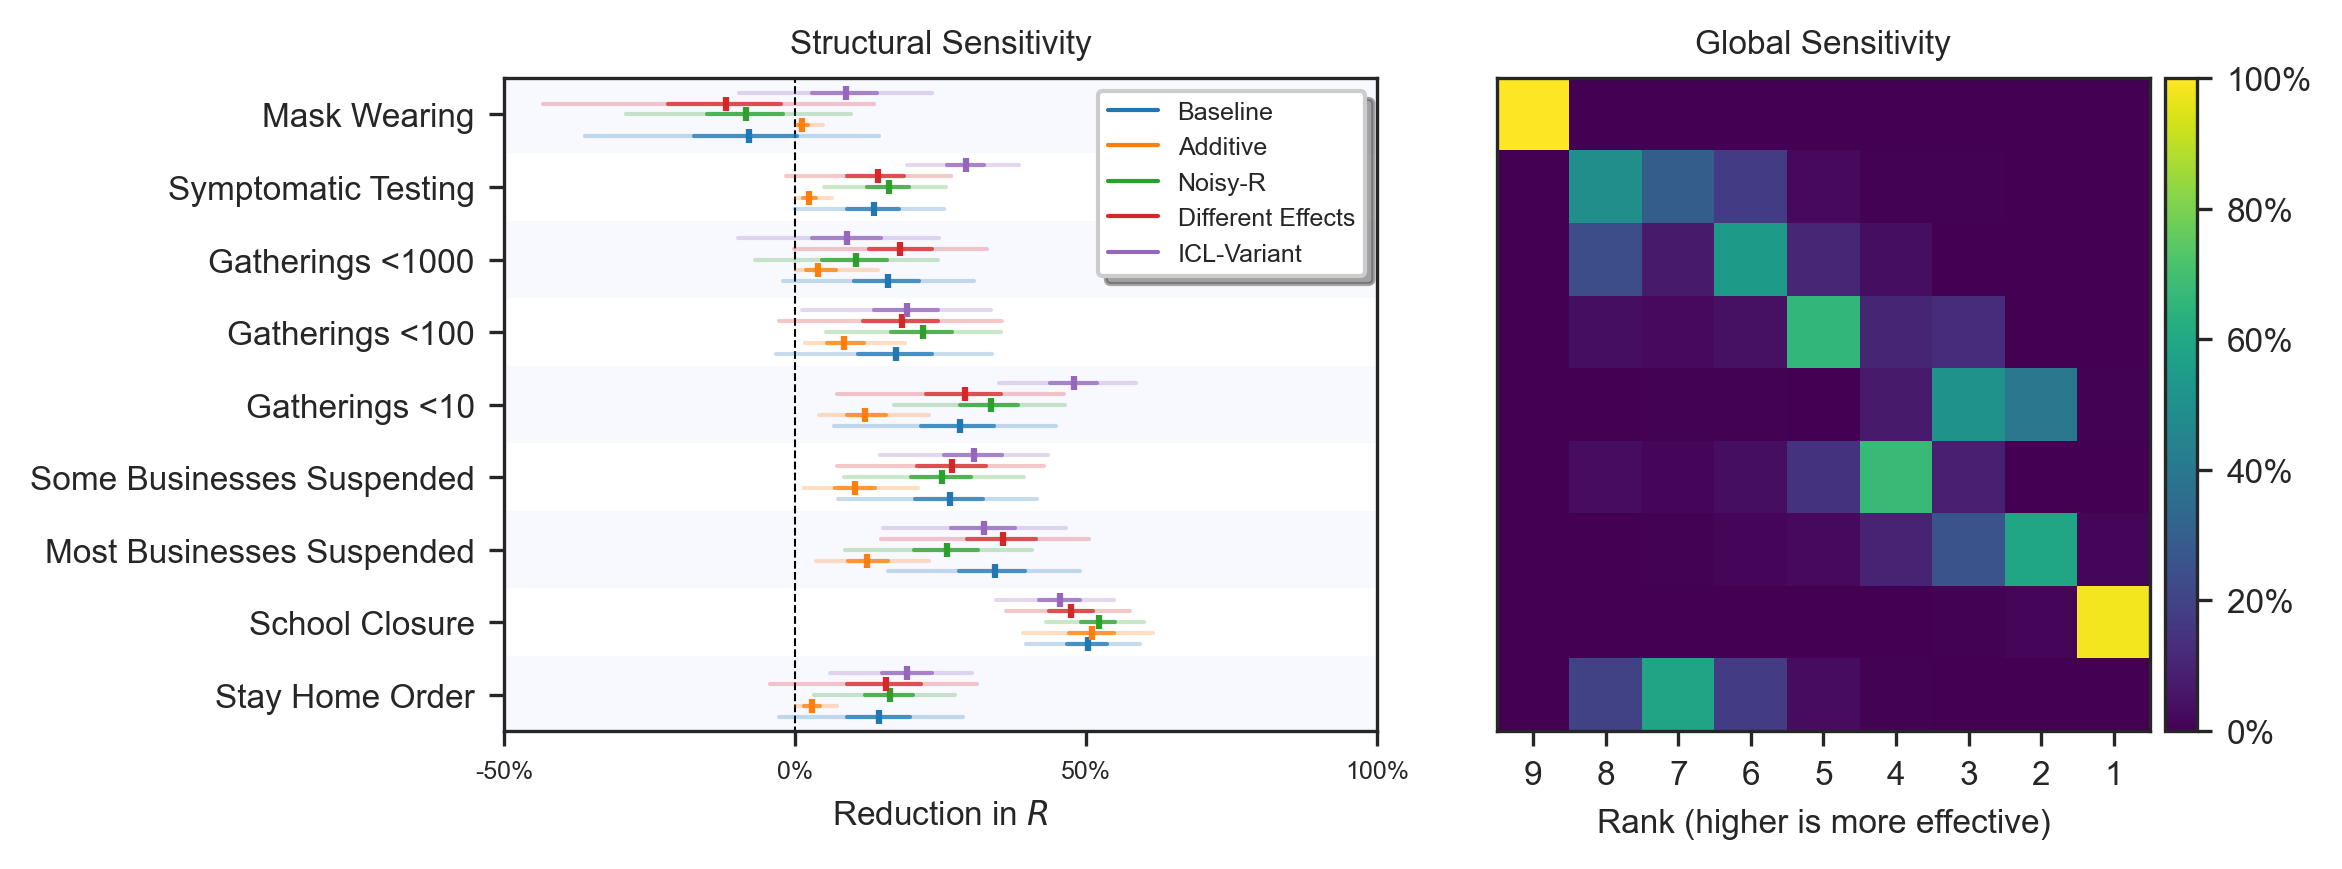

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.font_manager import FontProperties
from matplotlib.ticker import PercentFormatter

plt.figure(figsize=(8,3), dpi=300)
to_plot = ["baseline", "additive", "noisy-r7", "diff_effects", "ICL-Variant"]
colors = sns.color_palette()
labels = ["Baseline", "Additive", "Noisy-R", "Different Effects", "ICL-Variant"]
alphas = np.ones(len(to_plot))
y_off = np.linspace(-0.3, 0.3, len(to_plot))


plt.subplot(121)
plt.title("Structural Sensitivity", fontsize=8)
nF = len(derived_features)
plt.plot([0, 0], [1, -(nF)], "--k", linewidth=0.5)
xrange = np.array([-100, 100])
for height in range(0, nF, 2):
    plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="ghostwhite")
    
x_min = -50
x_max = 100
xtick_vals = np.arange(-100, 150, 50)
xtick_str = [f"{x:.0f}%" for x in xtick_vals]
plt.ylim([-(nF - 0.5), 0.5])

plt.yticks(-np.arange(nF), [f"{f[0]}" for f in derived_features], fontsize=8)
ax = plt.gca()

x_r = np.abs(x_min - x_max)
plt.xticks(xtick_vals, xtick_str, fontsize=6)
plt.xlabel("Reduction in $R$", fontsize=8)


for i, p in enumerate(to_plot):
    default_res, _ = grab_traces(p)
    add_trace_to_plot(default_res, y_off[i], colors[i], labels[i], alphas[i], additive=(p=="additive"))

plt.xlim([x_min, x_max])
plt.legend(fancybox=True, shadow=True, fontsize=6, loc="upper right")

plt.subplot(122)
rank_mat = np.loadtxt("rank_mat_c.txt")
im = plt.imshow(rank_mat, cmap="viridis")
plt.xticks(np.arange(9), np.arange(9, 0, -1), fontsize=8)
plt.xlabel("Rank (higher is more effective)", fontsize=8)
plt.yticks([])
plt.title("Global Sensitivity", fontsize=8)

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, format=PercentFormatter())
ax = plt.gca()
ax.tick_params(axis="both", which="major", labelsize=8)

plt.tight_layout()
plt.savefig(f"FigureSSA1.pdf", bbox_inches='tight')

In [21]:
to_plot = ["baseline", "additive", "diff_effects", "noisy-r7", "icl_close", "nonoise", "ICL-Variant"]
colors = sns.color_palette("bright")
labels = ["Baseline", "Additive Effect", "Noisy-$R$", "Different Effects", "Discrete Renewal\n(Flaxman et. al. [8])", "Journal No Noise", "ICL Full"]
all_scores_dicts = []

for p in range(len(to_plot)):
    default_res, cat_sen = grab_traces_categorised(to_plot[p])
    score, cat_scores_dict = cat_sen_to_scores(default_res, cat_sen)
    all_scores_dicts.append(cat_scores_dict)

Categorised: baseline
File data_mobility_no_work_combined.txt not added - no category found
File data_mobility_rec_work_combined.txt not added - no category found
File default_combined.txt not added - no category found
Found 37 tests
Categorised: additive
File data_mobility_rec_work_combined_additive.txt not added - no category found
File data_mobility_no_work_combined_additive.txt not added - no category found
File default_combined_additive.txt not added - no category found
Found 36 tests
Categorised: diff_effects
File default_combined_dif.txt not added - no category found
File data_mobility_no_work_combined_dif.txt not added - no category found
File data_mobility_rec_work_combined_dif.txt not added - no category found
Found 37 tests
Categorised: noisy-r7
File default_combined_v3.txt not added - no category found
File fd_conf15_deaths15_combined_v3.txt not added - no category found
File fd_conf30_deaths15_combined_v3.txt not added - no category found
File fd_conf30_deaths30_combined_v

In [24]:
ll_scores = np.array([-0.1835 , -0.19295, -0.1963 , -0.1854 , -0.1712 , -0.18755,
       -0.18305])
model_names = ["journal", "noisyr", "journal-nonoise", "icl", "icl no noise", "diff effects", "additive"]

In [26]:
ll_scores = np.array([-0.1835 , -0.18305,  -0.18755,  -0.19295, -0.1712, -0.1963, -0.1854]) 

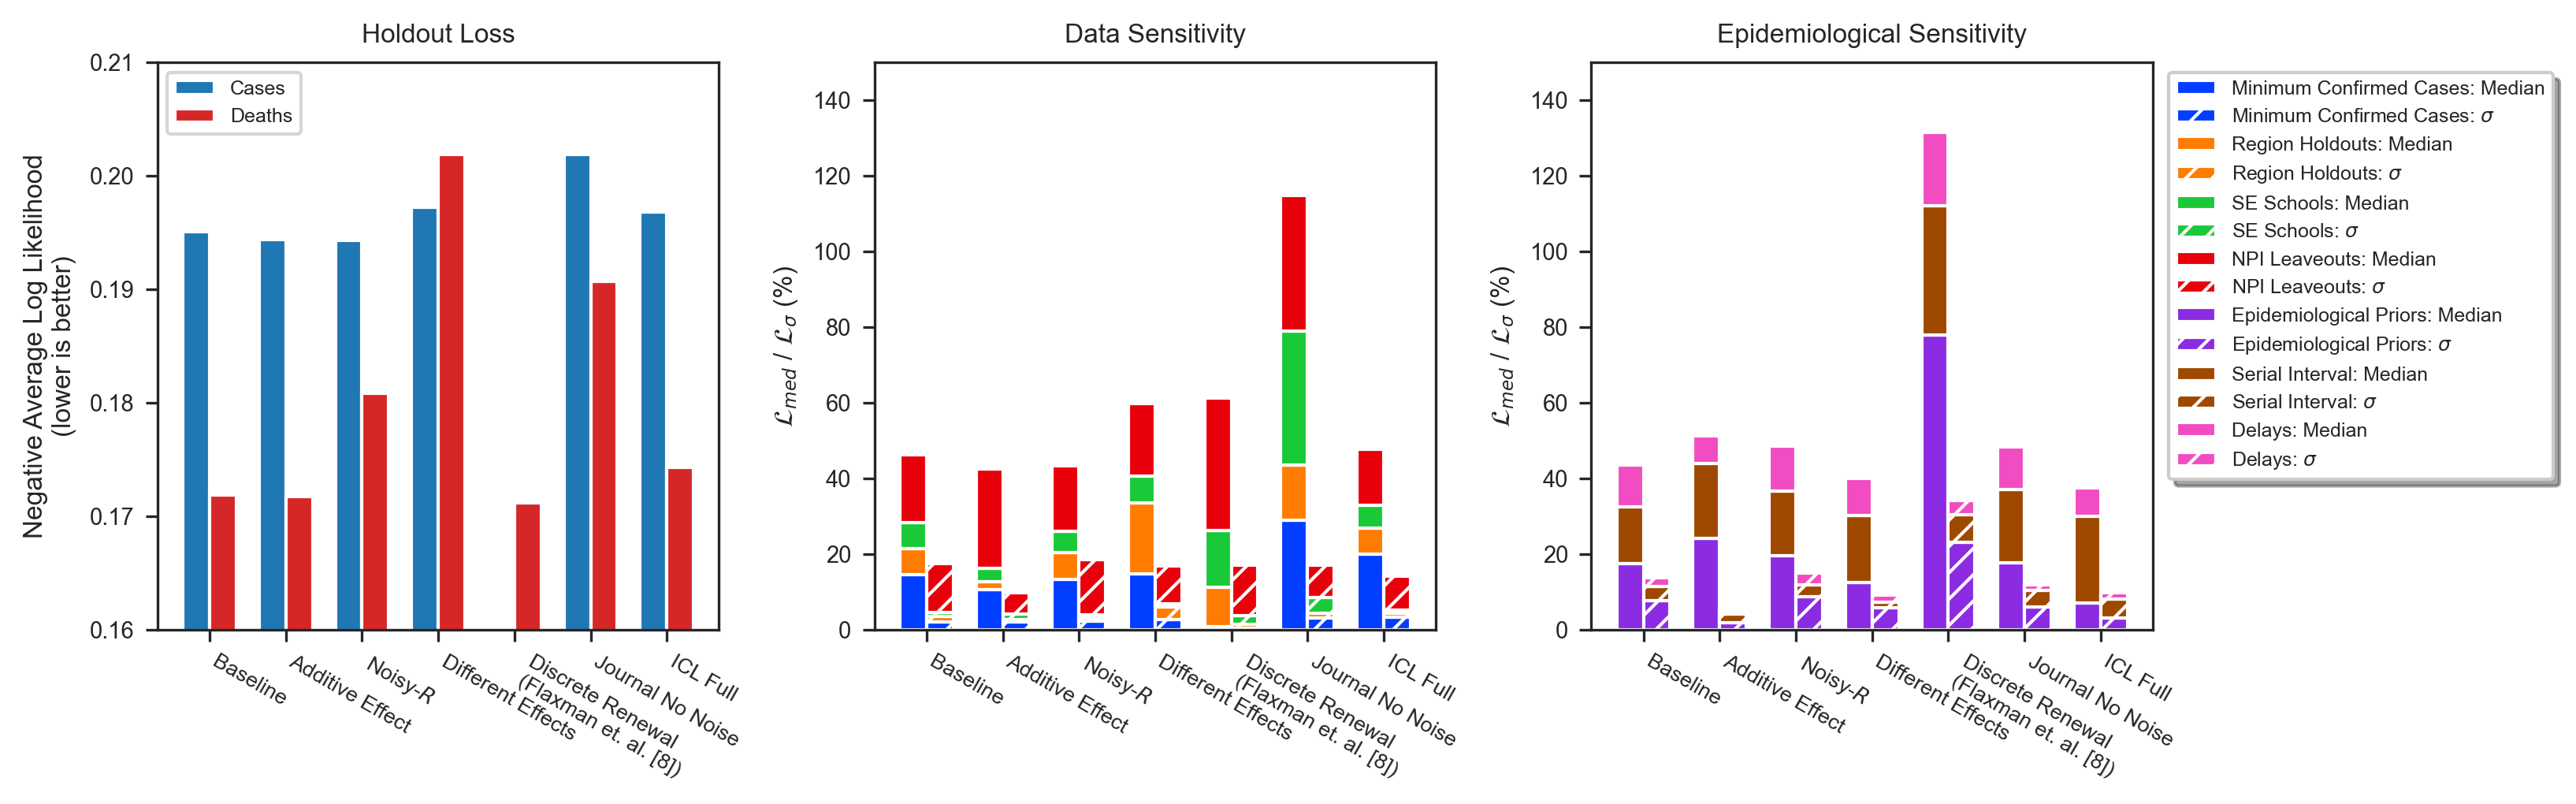

In [43]:
plt.figure(figsize=(11, 3.5), dpi=300)

plt.subplot(131)
cases_ll = [-0.1951,-0.1944, -0.1943, -0.1972, 0, -0.2019, -0.1968]
deaths_ll = [-0.1719,-0.1717, -0.1808, -0.2019, -0.1712, -0.1907, -0.1743]

width = 0.35
plt.bar(np.arange(len(to_plot))-width/2, -np.array(cases_ll), width=width, label="Cases", color="tab:blue")
plt.bar(np.arange(len(to_plot))+width/2, -np.array(deaths_ll), width=width, label="Deaths", color="tab:red")

plt.ylim([0.16, 0.21])
plt.title("Holdout Loss", fontsize=8)
plt.ylabel("Negative Average Log Likelihood\n(lower is better)", fontsize=8)
plt.yticks(fontsize=7)
plt.xticks(list(range(len(labels))), labels, fontsize=6.5, rotation=-30, ha="left")

plt.legend(loc="upper left", fontsize=6)

plt.subplot(132)

data_keys = ['Minimum Confirmed Cases', 'Region Holdouts', 'SE Schools', 'NPI Leaveouts']
epi_keys = ['Epidemiological Priors', 'Serial Interval', 'Delays']

n_cat = len(data_keys)
width = 0.35
for p in range(len(to_plot)):
    cat_scores_list = all_scores_dicts[p]
    rs_med = 0
    rs_std = 0
    for j, key in enumerate(data_keys):
        i = [n for n, _, _, _ in cat_scores_list].index(key)
        med_inc = cat_scores_list[i][2]
        std_inc = cat_scores_list[i][3]
        
        if p == 0:
            plt.bar(p-width/2, med_inc, bottom=rs_med, width=width, label=f"{key}: Median", color=colors[j])
            rs_med += med_inc
            plt.bar(p+width/2, std_inc, bottom=rs_std, width=width, label=f"{key}: $\sigma$", color=colors[j], hatch="///")
            rs_std += std_inc
        else:
            plt.bar(p-width/2, med_inc, bottom=rs_med, width=width, color=colors[j])
            rs_med += med_inc
            plt.bar(p+width/2, std_inc, bottom=rs_std, width=width, color=colors[j], hatch="///")
            rs_std += std_inc

lines_leg, labels_leg = plt.gca().get_legend_handles_labels()
plt.ylim([0, 150])
plt.title("Data Sensitivity", fontsize=8)
plt.ylabel("$\mathcal{L}_{med}$ / $\mathcal{L}_\sigma$ (%)", fontsize=8)
plt.yticks(fontsize=7)
plt.xticks(list(range(len(labels))), labels, fontsize=6.5, rotation=-30, ha="left")

plt.subplot(133)

n_cat = len(data_keys)
width = 0.35
for p in range(len(to_plot)):
    cat_scores_list = all_scores_dicts[p]
    rs_med = 0
    rs_std = 0
    for j, key in enumerate(epi_keys):
        i = [n for n, _, _, _ in cat_scores_list].index(key)
        med_inc = cat_scores_list[i][2]
        std_inc = cat_scores_list[i][3]
        if p == 0:
            plt.bar(p-width/2, med_inc, bottom=rs_med, width=width, label=f"{key}: Median", color=colors[j+len(data_keys)])
            rs_med += med_inc
            plt.bar(p+width/2, std_inc, bottom=rs_std, width=width, label=f"{key}: $\sigma$", color=colors[j+len(data_keys)], hatch="///")
            rs_std += std_inc
        else:
            plt.bar(p-width/2, med_inc, bottom=rs_med, width=width, color=colors[j+len(data_keys)])
            rs_med += med_inc
            plt.bar(p+width/2, std_inc, bottom=rs_std, width=width, color=colors[j+len(data_keys)], hatch="///")
            rs_std += std_inc
plt.title("Epidemiological Sensitivity", fontsize=8)

lines2_leg, labels2_leg = plt.gca().get_legend_handles_labels()
plt.legend(lines_leg+lines2_leg, labels_leg+labels2_leg, shadow=True, fancybox=True, fontsize=6, bbox_to_anchor=(1.01, 1))
plt.ylabel("$\mathcal{L}_{med}$ / $\mathcal{L}_\sigma$ (%)", fontsize=8)
plt.yticks(fontsize=7)
plt.xticks(list(range(len(labels))), labels, fontsize=6.5, rotation=-30, ha="left")
plt.ylim([0, 150])

plt.tight_layout()
plt.savefig(f"FigureSSA2.pdf", bbox_inches='tight')

Categorised: baseline
File data_mobility_no_work_combined.txt not added - no category found
File data_mobility_rec_work_combined.txt not added - no category found
File default_combined.txt not added - no category found
Found 37 tests
baseline : score 0.93 med 0.98 std 0.11 min 0.48 
Categorised: additive
File data_mobility_rec_work_combined_additive.txt not added - no category found
File data_mobility_no_work_combined_additive.txt not added - no category found
File default_combined_additive.txt not added - no category found
Found 36 tests
additive : score 0.95 med 0.97 std 0.07 min 0.68 
Categorised: diff_effects
File default_combined_dif.txt not added - no category found
File data_mobility_no_work_combined_dif.txt not added - no category found
File data_mobility_rec_work_combined_dif.txt not added - no category found
Found 37 tests
diff_effects : score 0.94 med 0.98 std 0.09 min 0.62 
Categorised: noisy-r7
File default_combined_v3.txt not added - no category found
File fd_conf15_death

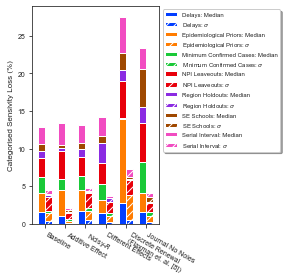

In [20]:
for p in range(len(to_plot)):
    default_res, cat_sen = grab_traces_categorised(to_plot[p])
    default_rank = stats.rankdata(np.median(default_res, axis=0))
    all_rankings = [stats.rankdata(res[0]) for l in cat_sen.values() for res in l]
    scores = [stats.spearmanr(default_rank, r)[0] for r in all_rankings]
    print(f"{to_plot[p]} : score {np.mean(scores):.2f} med {np.median(scores):.2f} std {np.std(scores):.2f} min {np.min(scores):.2f} ")
    plt.bar(p, np.mean(scores), color=colors[0])

plt.ylabel("Rank Stability Score", fontsize=8)
plt.yticks(fontsize=7)
plt.xticks(list(range(len(labels))), labels, fontsize=7, rotation=-30, ha="left")
plt.ylim([0.75, 1])

plt.subplot(122)
width = 0.35

# colors = ["tab:blue", "tab:green", "tab:red", "tab:orange", "tab:purple", "tab:grey"]
for p in range(len(to_plot)):
    default_res, cat_sen = grab_traces_categorised(to_plot[p])
    score, cat_scores_dict = cat_sen_to_scores(default_res, cat_sen)
    rs_med = 0
    rs_std = 0
    cat_scores = list(zip([n for n, ss, med, std in cat_scores_dict], [ss for n, ss, med, std in cat_scores_dict], [med for n, ss, med, std in cat_scores_dict], [std for n, ss, med, std in cat_scores_dict]))
    cat_scores.sort(key = lambda cs: cs[0])
    n_cat = len(cat_scores)
    for i, (name, score_increment, med_inc, std_inc) in enumerate(cat_scores):
        if p == 0:
            plt.bar(p-width/2, med_inc/n_cat, bottom=rs_med, width=width, label=f"{name}: Median", color=colors[i])
            rs_med += med_inc/n_cat
            plt.bar(p+width/2, std_inc/n_cat, bottom=rs_std, width=width, label=f"{name}: $\sigma$", color=colors[i], hatch="///")
            rs_std += std_inc/n_cat
        else:
            plt.bar(p-width/2, med_inc/n_cat, bottom=rs_med, width=width, color=colors[i])
            rs_med += med_inc/n_cat
            plt.bar(p+width/2, std_inc/n_cat, bottom=rs_std, width=width, color=colors[i], hatch="///")
            rs_std += std_inc/n_cat
            
leg = plt.legend(shadow=True, fancybox=True, fontsize=6, bbox_to_anchor=(1.01, 1))
plt.ylabel("Categorised Sensivity Loss (%)", fontsize=8)
plt.yticks(fontsize=7)
plt.xticks(list(range(len(labels))), labels, fontsize=7, rotation=-30, ha="left")
plt.tight_layout()

plt.savefig(f"FigureSSA2.pdf", bbox_inches='tight')